Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
eps = np.finfo(float).eps
from numpy import log2 as log

In [3]:
outlook = 'overcast,overcast,overcast,overcast,rainy,rainy,rainy,rainy,rainy,sunny,sunny,sunny,sunny,sunny'.split(',')
temp = 'hot,cool,mild,hot,mild,cool,cool,mild,mild,hot,hot,mild,cool,mild'.split(',')
humidity = 'high,normal,high,normal,high,normal,normal,normal,high,high,high,high,normal,normal'.split(',')
windy = 'FALSE,TRUE,TRUE,FALSE,FALSE,FALSE,TRUE,FALSE,TRUE,FALSE,TRUE,FALSE,FALSE,TRUE'.split(',')
play = 'yes,yes,yes,yes,yes,yes,no,yes,no,no,no,no,yes,yes'.split(',')

In [4]:
dataset ={'outlook':outlook,'temp':temp,'humidity':humidity,'windy':windy,'play':play}
df = pd.DataFrame(dataset,columns=['outlook','temp','humidity','windy','play'])
df

,outlook,temp,humidity,windy,play
0,overcast,hot,high,FALSE,yes
1,overcast,cool,normal,TRUE,yes
2,overcast,mild,high,TRUE,yes
3,overcast,hot,normal,FALSE,yes
4,rainy,mild,high,FALSE,yes
5,rainy,cool,normal,FALSE,yes
6,rainy,cool,normal,TRUE,no
7,rainy,mild,normal,FALSE,yes
8,rainy,mild,high,TRUE,no
9,sunny,hot,high,FALSE,no


1. find the Entropy and then Information Gain for splitting the data set.


In [5]:
##1. claculate entropy o the whole dataset

entropy_node = 0  #Initialize Entropy
values = df.play.unique()  #Unique objects - 'Yes', 'No'
for value in values:
    fraction = df.play.value_counts()[value]/len(df.play)  
    entropy_node += -fraction*np.log2(fraction)

print(f'Values: {values}')
print(f'entropy_node: {entropy_node}')      

Values: ['yes' 'no']
entropy_node: 0.9402859586706309


2. Now define a function {ent} to calculate entropy of each attribute :


In [6]:
def ent(df,attribute):
    target_variables = df.play.unique()  #This gives all 'Yes' and 'No'
    variables = df[attribute].unique()    #This gives different features in that attribute (like 'Sweet')


    entropy_attribute = 0
    for variable in variables:
        entropy_each_feature = 0
        for target_variable in target_variables:
            num = len(df[attribute][df[attribute]==variable][df.play ==target_variable]) #numerator
            den = len(df[attribute][df[attribute]==variable])  #denominator
            fraction = num/(den+eps)  #pi
            entropy_each_feature += -fraction*log(fraction+eps) #This calculates entropy for one feature like 'Sweet'
        fraction2 = den/len(df)
        entropy_attribute += -fraction2*entropy_each_feature   #Sums up all the entropy ETaste

    return(abs(entropy_attribute))

In [7]:
a_entropy = {k:ent(df,k) for k in df.keys()[:-1]}
a_entropy

{'outlook': 0.6935361388961914,
 'temp': 0.9110633930116756,
 'humidity': 0.7884504573082889,
 'windy': 0.892158928262361}

3. Calculate Info gain of each attribute :


IG(attr) = entropy of dataset - entropy of attribute

In [9]:
def ig(e_dataset,e_attr):
    return(e_dataset-e_attr)

In [10]:
#entropy_node = entropy of dataset
#a_entropy[k] = entropy of k(th) attr
IG = {k:ig(entropy_node,a_entropy[k]) for k in a_entropy}
IG

{'outlook': 0.24674981977443955,
 'temp': 0.029222565658955313,
 'humidity': 0.15183550136234203,
 'windy': 0.04812703040826993}

In [8]:
def find_entropy(df):
    Class = df.keys()[-1]   #To make the code generic, changing target variable class name
    entropy = 0
    values = df[Class].unique()
    for value in values:
        fraction = df[Class].value_counts()[value]/len(df[Class])
        entropy += -fraction*np.log2(fraction)
    return entropy
  
  
def find_entropy_attribute(df,attribute):
  Class = df.keys()[-1]   #To make the code generic, changing target variable class name
  target_variables = df[Class].unique()  #This gives all 'Yes' and 'No'
  variables = df[attribute].unique()    #This gives different features in that attribute (like 'Hot','Cold' in Temperature)
  entropy2 = 0
  for variable in variables:
      entropy = 0
      for target_variable in target_variables:
          num = len(df[attribute][df[attribute]==variable][df[Class] ==target_variable])
          den = len(df[attribute][df[attribute]==variable])
          fraction = num/(den+eps)
          entropy += -fraction*log(fraction+eps)
      fraction2 = den/len(df)
      entropy2 += -fraction2*entropy
  return abs(entropy2)


def find_winner(df):
    Entropy_att = []
    IG = []
    for key in df.keys()[:-1]:
#         Entropy_att.append(find_entropy_attribute(df,key))
        IG.append(find_entropy(df)-find_entropy_attribute(df,key))
    return df.keys()[:-1][np.argmax(IG)]
  
  
def get_subtable(df, node,value):
  return df[df[node] == value].reset_index(drop=True)


def buildTree(df,tree=None): 
    Class = df.keys()[-1]   #To make the code generic, changing target variable class name
    
    #Here we build our decision tree

    #Get attribute with maximum information gain
    node = find_winner(df)
    
    #Get distinct value of that attribute e.g Salary is node and Low,Med and High are values
    attValue = np.unique(df[node])
    
    #Create an empty dictionary to create tree    
    if tree is None:                    
        tree={}
        tree[node] = {}
    
   #We make loop to construct a tree by calling this function recursively. 
    #In this we check if the subset is pure and stops if it is pure. 

    for value in attValue:
        
        subtable = get_subtable(df,node,value)
        clValue,counts = np.unique(subtable[Class],return_counts=True)                        
        
        if len(counts)==1:#Checking purity of subset
            tree[node][value] = clValue[0]                                                    
        else:        
            tree[node][value] = buildTree(subtable) #Calling the function recursively 
                   
    return tree

In [11]:
t  = buildTree(df)
import pprint
pprint.pprint(t)

{'outlook': {'overcast': 'yes',
             'rainy': {'windy': {'FALSE': 'yes', 'TRUE': 'no'}},
             'sunny': {'humidity': {'high': 'no', 'normal': 'yes'}}}}


In [12]:
import pydot
import uuid

def generate_unique_node():
    """ Generate a unique node label."""
    return str(uuid.uuid1())

def create_node(graph, label, shape='oval'):
    node = pydot.Node(generate_unique_node(), label=label, shape=shape)
    graph.add_node(node)
    return node

def create_edge(graph, node_parent, node_child, label):
    link = pydot.Edge(node_parent, node_child, label=label)
    graph.add_edge(link)
    return link

def walk_tree(graph, dictionary, prev_node=None):
    """ Recursive construction of a decision tree stored as a dictionary """
    for parent, child in dictionary.items():
        # root
        if not prev_node: 
            root = create_node(graph, parent)
            walk_tree(graph, child, root)
            continue
            
        # node
        if isinstance(child, dict):
            for p, c in child.items():
                n = create_node(graph, p)
                create_edge(graph, prev_node, n, str(parent))
                walk_tree(graph, c, n)
    
        # leaf
        else: 
            leaf = create_node(graph, str(child), shape='box')
            create_edge(graph, prev_node, leaf, str(parent))

# def plot_tree(dictionary, filename="DecisionTree.png"):
#     graph = pydot.Dot(graph_type='graph')
#     walk_tree(graph, tree)
#     graph.write_png(filename)
        

# tree = {'salary': {'41k-45k': 'junior', '46k-50k': {'department': {'marketing': 'senior', 'sales': 'senior', 'systems': 'junior'}}, '36k-40k': 'senior', '26k-30k': 'junior', '31k-35k': 'junior', '66k-70k': 'senior'}}
tree={'outlook': {'overcast': 'yes',
             'rainy': {'windy': {'FALSE': 'yes', 'TRUE': 'no'}},
             'sunny': {'humidity': {'high': 'no', 'normal': 'yes'}}}}
# plot_tree(tree)
graph = pydot.Dot(graph_type='digraph')
walk_tree(graph, tree)

graph.write_png("DecisionTree.png")
# print(type())


Org image shape -->  (291, 404, 3)


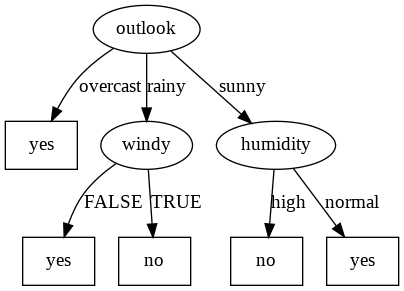

In [13]:
import cv2
from google.colab.patches import cv2_imshow # for image display
clusters = 5 # try changing it

path=""
img = cv2.imread(path, 1)
org_img = img
print('Org image shape --> ',img.shape)
cv2_imshow(img)
cv2.destroyAllWindows()


In [14]:
import pandas as pd

dt = {'Outlook': {'Overcast': 'Yes', 'Rain': {'Wind': {'Strong': 'No', 'Weak': 'Yes'}}, 'Sunny': {'Temperature': {'Cool': 'Yes', 'Hot': 'No', 'Mild': 'No'}}}}

df = pd.DataFrame(data=[['Sunny', 'Mild', 'Normal', 'Strong', 'Yes']],columns=['Outlook', 'Temperature', 'Humidity', 'Wind', 'Decision'])

def fun(d, t):
    """
    d -- decision tree dictionary
    t -- testing examples in form of pandas dataframe
    """
    res = []
    for _, e in t.iterrows():
        res.append(predict(d, e))
    return res

def predict(d, e):
    """
    d -- decision tree dictionary
    e -- a testing example in form of pandas series
    """
    current_node = list(d.keys())[0]
    current_branch = d[current_node][e[current_node]]
    # if leaf node value is string then its a decision
    if isinstance(current_branch, str):
        return current_branch
    # else use that node as new searching subtree
    else:
        return predict(current_branch, e)

print(fun(dt, df))

['No']
